In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import statsmodels.formula.api as smf
import missingno as msno 





In [2]:

features = pd.read_csv("../0_DataPreparation/features.csv")
pd.set_option('display.max_columns', None)
features

,id,Datum,Warengruppe,Umsatz,Bewoelkung,Temperatur,Windgeschwindigkeit,Rain,KielerWoche,CPI,Unemployment,GDP,Rain_Sum_8to18,Rain_8to18,Temp_5d_avg,Temp_above_avg,Temp_below_avg,Tmax,Tmax_gt25,Hot_HeavyRain,Wochentag,Wochenende,Monat,Feiertag,Schulferien,Residual,Temperatureclass_enc,Cloudclass_enc,Windclass_enc,Weather_After_Rain,Weather_Fog,Weather_Other,Weather_Rain,Weather_Showers_and_Thunderstorms,Weather_Snow_and_Ice
0,1307011,2013-07-01,1,148.828353,6.0,17.8375,15.0,1.567431,0,93.5,6.8,728.23,1.442231,1,14.4575,1,0,18.199883,0,0,0,0,7,0,1,0,2,1,2,1,0,0,0,0,0
1,1307021,2013-07-02,1,159.793757,3.0,17.3125,10.0,0.140967,0,93.5,6.8,728.23,0.140967,0,15.4100,0,0,18.319065,0,0,1,0,7,0,1,0,2,1,2,0,0,1,0,0,0
2,1307031,2013-07-03,1,111.885594,7.0,21.0750,6.0,6.276774,0,93.5,6.8,728.23,5.542491,1,17.0150,1,0,22.473013,0,0,2,0,7,0,1,0,2,0,0,0,0,0,1,0,0
3,1307041,2013-07-04,1,168.864941,7.0,18.8500,7.0,0.126180,0,93.5,6.8,728.23,0.126180,0,17.8175,0,0,19.594244,0,0,3,0,7,0,1,0,2,0,0,1,0,0,0,0,0
4,1307051,2013-07-05,1,171.280754,5.0,19.9750,12.0,1.255988,0,93.5,6.8,728.23,1.255988,1,19.0100,0,0,20.406262,0,0,4,0,7,0,1,0,2,1,2,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11159,1812226,2018-12-22,6,NaN,8.0,4.3000,4.0,0.392234,0,98.5,4.9,881.52,0.243416,0,4.7575,0,0,5.505522,0,0,5,1,12,0,1,0,0,0,0,0,0,1,0,0,0
11160,1812236,2018-12-23,6,NaN,7.0,6.4500,9.0,4.244212,0,98.5,4.9,881.52,1.981295,1,4.9850,0,0,6.818994,0,0,6,1,12,0,1,0,1,0,0,0,0,0,1,0,0
11161,1812246,2018-12-24,6,NaN,7.0,2.5000,10.0,0.000000,0,98.5,4.9,881.52,0.000000,0,4.8500,0,0,4.503302,0,0,0,0,12,0,1,0,0,0,2,1,0,0,0,0,0
11162,1812276,2018-12-27,6,NaN,7.0,7.1250,12.0,0.000000,0,98.5,4.9,881.52,0.000000,0,6.0700,0,0,7.492173,0,0,3,0,12,0,1,0,1,0,2,1,0,0,0,0,0


<Axes: >

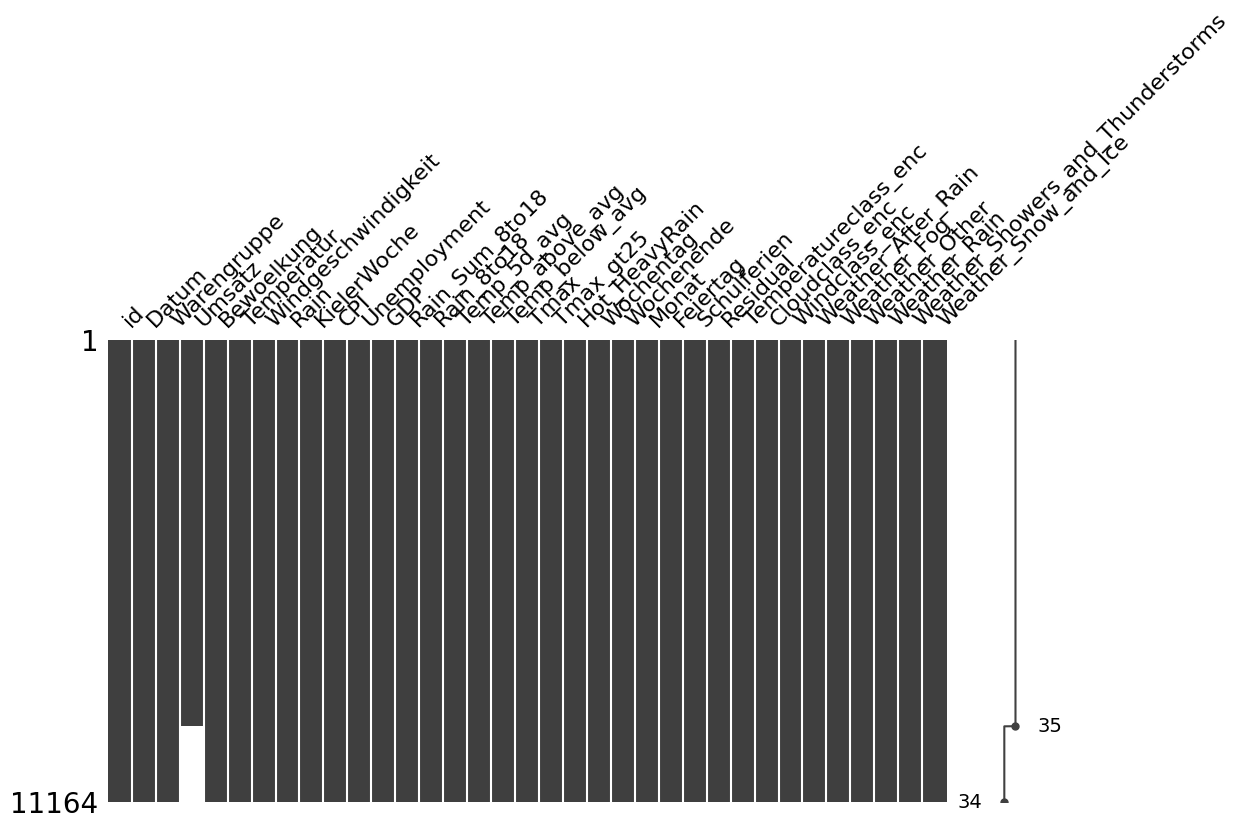

In [3]:
msno.matrix(features, figsize=(12, 6))

In [4]:
features.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11164 entries, 0 to 11163
Data columns (total 35 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   id                                 11164 non-null  int64  
 1   Datum                              11164 non-null  object 
 2   Warengruppe                        11164 non-null  int64  
 3   Umsatz                             9334 non-null   float64
 4   Bewoelkung                         11164 non-null  float64
 5   Temperatur                         11164 non-null  float64
 6   Windgeschwindigkeit                11164 non-null  float64
 7   Rain                               11164 non-null  float64
 8   KielerWoche                        11164 non-null  int64  
 9   CPI                                11164 non-null  float64
 10  Unemployment                       11164 non-null  float64
 11  GDP                                11164 non-null  flo

In [5]:
features.iloc[:,20:].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11164 entries, 0 to 11163
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   Wochentag                          11164 non-null  int64
 1   Wochenende                         11164 non-null  int64
 2   Monat                              11164 non-null  int64
 3   Feiertag                           11164 non-null  int64
 4   Schulferien                        11164 non-null  int64
 5   Residual                           11164 non-null  int64
 6   Temperatureclass_enc               11164 non-null  int64
 7   Cloudclass_enc                     11164 non-null  int64
 8   Windclass_enc                      11164 non-null  int64
 9   Weather_After_Rain                 11164 non-null  int64
 10  Weather_Fog                        11164 non-null  int64
 11  Weather_Other                      11164 non-null  int64
 12  Weather_Rain      

## Time Split
We Split the dataset into training, validation and test data

In [6]:
train_end_date = '2017-07-31'
validation_end_date = '2018-07-31'


train_data = features[features['Datum']<=train_end_date].set_index("id")
vali_data = features[(features['Datum']> train_end_date) & (features['Datum']<=validation_end_date)].set_index("id")
test_data = features[(features['Datum']> validation_end_date)].set_index("id")

train_data


,Datum,Warengruppe,Umsatz,Bewoelkung,Temperatur,Windgeschwindigkeit,Rain,KielerWoche,CPI,Unemployment,GDP,Rain_Sum_8to18,Rain_8to18,Temp_5d_avg,Temp_above_avg,Temp_below_avg,Tmax,Tmax_gt25,Hot_HeavyRain,Wochentag,Wochenende,Monat,Feiertag,Schulferien,Residual,Temperatureclass_enc,Cloudclass_enc,Windclass_enc,Weather_After_Rain,Weather_Fog,Weather_Other,Weather_Rain,Weather_Showers_and_Thunderstorms,Weather_Snow_and_Ice
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1307011,2013-07-01,1,148.828353,6.0,17.8375,15.0,1.567431,0,93.5,6.8,728.23,1.442231,1,14.4575,1,0,18.199883,0,0,0,0,7,0,1,0,2,1,2,1,0,0,0,0,0
1307021,2013-07-02,1,159.793757,3.0,17.3125,10.0,0.140967,0,93.5,6.8,728.23,0.140967,0,15.4100,0,0,18.319065,0,0,1,0,7,0,1,0,2,1,2,0,0,1,0,0,0
1307031,2013-07-03,1,111.885594,7.0,21.0750,6.0,6.276774,0,93.5,6.8,728.23,5.542491,1,17.0150,1,0,22.473013,0,0,2,0,7,0,1,0,2,0,0,0,0,0,1,0,0
1307041,2013-07-04,1,168.864941,7.0,18.8500,7.0,0.126180,0,93.5,6.8,728.23,0.126180,0,17.8175,0,0,19.594244,0,0,3,0,7,0,1,0,2,0,0,1,0,0,0,0,0
1307051,2013-07-05,1,171.280754,5.0,19.9750,12.0,1.255988,0,93.5,6.8,728.23,1.255988,1,19.0100,0,0,20.406262,0,0,4,0,7,0,1,0,2,1,2,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1612226,2016-12-22,6,54.322960,7.0,5.2500,8.0,1.991653,0,95.6,5.8,817.74,0.000000,0,4.6250,0,0,5.601336,0,0,3,0,12,0,0,0,1,0,0,0,0,0,1,0,0
1612236,2016-12-23,6,133.499200,7.0,6.3750,9.0,0.471172,0,95.6,5.8,817.74,0.000000,0,4.5000,0,0,6.805806,0,0,4,0,12,0,1,0,1,0,0,0,1,0,0,0,0
1612246,2016-12-24,6,39.577538,6.0,6.1250,14.0,8.133034,0,95.6,5.8,817.74,2.044841,1,4.5750,0,0,6.796605,0,0,5,1,12,0,1,0,1,1,2,0,0,0,0,1,0


## Feature Selection
Define differnt groups of features for testing.

In [12]:
# Set 'id' as index
df = train_data

# Drop rows with missing values for simplicity in this baseline modeling
df_clean = df.dropna()

groups = {
    "Zeit" : "C(Wochentag) + C(Monat) + Wochenende",
    "Wetter" : "C(Temperatureclass_enc) + C(Cloudclass_enc) + C(Windclass_enc) + Hot_HeavyRain",
    "Wetter_Stats" : "Rain_8to18 + Temp_above_avg + Temp_below_avg + Temp_5d_avg + Tmax + Tmax_gt25 ",
    "Wetter_Group" : "Weather_Other + Weather_Rain + Weather_After_Rain + Weather_Showers_and_Thunderstorms + Weather_Snow_and_Ice + Weather_Fog",
    "Product" : "C(Warengruppe)",
    "Ökonomie": "CPI + Unemployment + GDP",
    "Holiday" : "Schulferien + KielerWoche + Feiertag",
    "Residual": "Residual"
}

# Define a list of formulas for different baseline models
formulas = {
    "Zeit": f"Umsatz ~ {groups['Zeit']}",
    "Wetter": f"Umsatz ~ {groups['Wetter']}",
    "Wetter+Stats": f"Umsatz ~ {groups['Wetter']} + {groups['Wetter_Stats']}",
    "Product": f"Umsatz ~ {groups['Product']}",
    "Ökonomie": f"Umsatz ~ {groups['Ökonomie']}",
    "Zeit+Wetter": f"Umsatz ~ {groups['Zeit']} + {groups['Wetter']}",
    "Zeit+Stats": f"Umsatz ~ {groups['Zeit']} + {groups['Wetter_Stats']}",
    "Zeit+Product": f"Umsatz ~ {groups['Zeit']} + {groups['Product']}",
    "Zeit+Ökonomie": f"Umsatz ~ {groups['Zeit']} + {groups['Ökonomie']}",
    "Zeit+Holiday": f"Umsatz ~ {groups['Zeit']} + {groups['Holiday']}",
    "Zeit+Wetter+Product": f"Umsatz ~ {groups['Zeit']} + {groups['Wetter']} + {groups['Product']}",
    "Vollmodell": f"Umsatz ~ {groups['Zeit']} + {groups['Wetter']} + {groups['Wetter_Stats']} + {groups['Product']} + {groups['Ökonomie']} + {groups['Holiday']}",
    "Vollmodell+": f"Umsatz ~ {groups['Zeit']} + {groups['Wetter']} + {groups['Wetter_Stats']} + {groups['Wetter_Group']} + {groups['Product']} + {groups['Ökonomie']} + {groups['Holiday']}",
    "Residual+Vollmodell": f"Umsatz ~ {groups['Zeit']} + {groups['Wetter']} + {groups['Wetter_Stats']} + {groups['Product']} + {groups['Ökonomie']} + {groups['Holiday']} + {groups['Residual']}",
    "Residual+Vollmodell+": f"Umsatz ~ {groups['Zeit']} + {groups['Wetter']} + {groups['Wetter_Stats']} + {groups['Wetter_Group']} + {groups['Product']} + {groups['Ökonomie']} + {groups['Holiday']} + {groups['Residual']}"

}

# Fit models and collect performance metrics
results = []
for name, formula in formulas.items():
    model = smf.ols(formula, data=df_clean).fit()
    results.append({
        "Modell": name,
        "R²": round(model.rsquared, 4),
        "Adj. R²": round(model.rsquared_adj, 4),  
        # "AIC": round(model.aic, 2),
        # "BIC": round(model.bic, 2),
        "Anzahl Parameter": int(model.df_model + 1)
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results).sort_values(by="R²", ascending=False)
results_df

,Modell,R²,Adj. R²,Anzahl Parameter
14,Residual+Vollmodell+,0.8115,0.8103,48
13,Residual+Vollmodell,0.8114,0.8103,43
11,Vollmodell,0.7550,0.7536,42
12,Vollmodell+,0.7550,0.7535,47
10,Zeit+Wetter+Product,0.7363,0.7353,30
7,Zeit+Product,0.7355,0.7347,23
3,Product,0.6506,0.6503,6
9,Zeit+Holiday,0.1105,0.1081,21
8,Zeit+Ökonomie,0.1058,0.1034,21
6,Zeit+Stats,0.0989,0.0962,24


## Create the baseline model

In [13]:
model = smf.ols(formulas['Residual+Vollmodell'], data=train_data.dropna()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Umsatz   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     763.1
Date:                Thu, 03 Jul 2025   Prob (F-statistic):               0.00
Time:                        07:56:04   Log-Likelihood:                -41815.
No. Observations:                7493   AIC:                         8.372e+04
Df Residuals:                    7450   BIC:                         8.401e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                      -76.1452    297.820     -0.256      0.798    -659.956     507.665
C(Wochentag)[T.1]               -2.3418      2.790     -0.839      0.401      -7.811       3.127
C(Wochentag)[T.2]               -2.4938      2.801     -0.890      0.373      -7.984       2.996
C(Wochentag)[T.3]                2.7232      2.793      0.975      0.330      -2.752       8.198
C(Wochentag)[T.4]                6.4563      2.816      2.292      0.022       0.936      11.977
C(Wochentag)[T.5]               13.8082      1.613      8.562      0.000      10.647      16.970
C(Wochentag)[T.6]               22.8862      1.611     14.209      0.000      19.729      26.044
C(Monat)[T.2]                   23.6091      4.081      5.786      0.000      15.610      31.608
C(Monat)[T.3]                   11.9595      5.361      2.231      0.026       1.450      22.469
C(Monat)[T.4]                   19.8247      7.540      2.629      0.009       5.044      34.605
C(Monat)[T.5]                   36.9873     10.198      3.627      0.000      16.996      56.978
C(Monat)[T.6]                   45.0650     11.816      3.814      0.000      21.903      68.227
C(Monat)[T.7]                   79.8981      9.041      8.837      0.000      62.175      97.622
C(Monat)[T.8]                   95.1667      8.387     11.347      0.000      78.727     111.607
C(Monat)[T.9]                   41.2139      9.544      4.318      0.000      22.505      59.922
C(Monat)[T.10]                  36.6629      9.025      4.062      0.000      18.971      54.355
C(Monat)[T.11]                  17.8049      8.797      2.024      0.043       0.561      35.049
C(Monat)[T.12]                  14.5371      7.297      1.992      0.046       0.234      28.840
C(Temperatureclass_enc)[T.1]     0.0422      3.199      0.013      0.989      -6.229       6.314
C(Temperatureclass_enc)[T.2]     6.5382      5.307      1.232      0.218      -3.866      16.942
C(Temperatureclass_enc)[T.3]    -3.9055      9.658     -0.404      0.686     -22.838      15.027
C(Cloudclass_enc)[T.1]           2.4915      1.741      1.431      0.153      -0.922       5.905
C(Windclass_enc)[T.1]            3.5896      4.284      0.838      0.402      -4.809      11.988
C(Windclass_enc)[T.2]            0.8328      1.589      0.524      0.600      -2.281       3.947
C(Warengruppe)[T.2]            288.3249      2.380    121.125      0.000     283.659     292.991
C(Warengruppe)[T.3]             42.8076      2.380     17.984      0.000      38.142      47.474
C(Warengruppe)[T.4]            -32.4177      2.403    -13.491      0.000     -37.128     -27.707
C(Warengruppe)[T.5]            155.8185      2.382     65.425      0.000     151.150     160.487
C(Warengruppe)[T.6]            -22.3112      4.784     -4.664      0.000    

## Make a prediction

In [9]:
pred = model.predict(test_data).clip(lower=0)
pred_df = pred.rename("Umsatz").reset_index()
pred_df.to_csv("kaggle_baseline.csv", index=False)
